# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**a)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**b)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**c)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**d)** Importe la librería: `google.colab`.

In [277]:
# 1.a)
import os
import pickle
import datetime
from collections import defaultdict

In [278]:
# 1.b)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import dill
import json
import shelve

In [279]:
# 1.c)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [280]:
# 1.d)
# import google.colab
# from google.colab import files
# !conda install dill

### Transformo y genero los conjuntos de train y test

In [281]:
# 2.a)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                # ,transforms.Normalize()
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

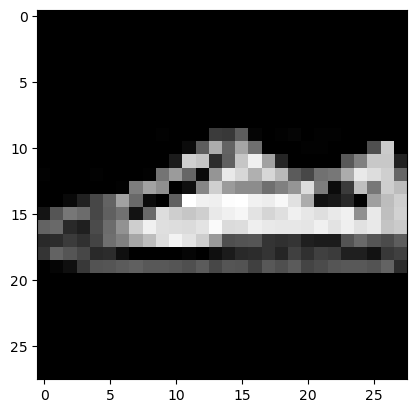

In [282]:
# Examinamos una imagen
i = np.random.randint(len(trainset))
images,labels = trainset[i]
plt.imshow(images.numpy().squeeze(),cmap='Greys_r')

In [283]:
# 2.c)
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

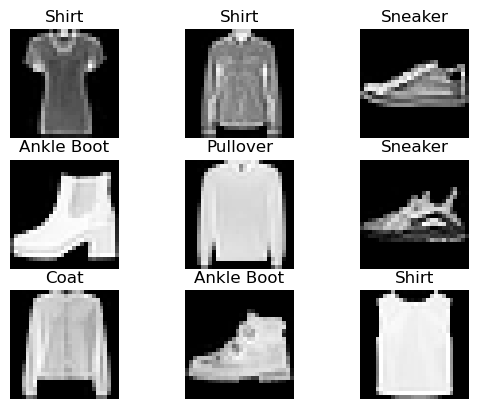

In [284]:
# 2.d)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

### Genero un custom dataset

In [285]:
# convierto a un custom dataframe para poder entregar el set de datos de manera que entrene a ambos lados de la red con la imagen achatada
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image , label = self.dataset[i]
        label = torch.flatten(image)
        return image , label
    
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)

### Defino la clase del autoencoder

In [286]:
class Autoencoder(nn.Module):
    def __init__(self,n):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,n),
            # nn.ReLU(),
            nn.Dropout(0.1),
            # nn.Linear(n,n),
            nn.ReLU(),
            # nn.Dropout(0.1),
            nn.Linear(n,28*28),
            nn.Dropout(0.1),
            nn.ReLU(),
            
        )
     
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)
    

In [287]:
n = 512
model = Autoencoder(n)

### Defino los loops de train y test

In [288]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # print('asd'+str(num_batches))
    sum_train_loss = 0
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        # print(pred)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_value = loss.item()
        sum_train_loss += loss_value
        if batch % 5 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    train_loss = sum_train_loss/num_batches
    return train_loss

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    # Definimos ciertas constantes  
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            sum_test_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            # sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    # frac_correct = sum_correct/size
    # print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

#### Defino una funcion para plotear las respuestas en funcion de la instancia del modelo con el que trabaje previamente

In [289]:
def model_test(model,image_name):
  figure = plt.figure()
  rows,cols = 3,2
  i = 0 # subplot index
  for row in range(1,rows+1):
      j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
      # Ploteamos la imagen original
      i += 1
      image,flatten_imagen = trainset[j]
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("original")
      plt.axis("off")
      plt.imshow(image.squeeze(),cmap="Greys_r")
      # Ploteamos la imagen predicha
      i += 1
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("predicha")
      plt.axis("off")
      #image_pred = model.imagen(image)
      #plt.imshow(image_pred,cmap="Greys_r")
      with torch.no_grad(): # 
          image_gpu = image
      pred_gpu = model(image_gpu)
      pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
      plt.imshow(pred_cpu,cmap="Greys_r")    
      
  plt.savefig(image_name)
  plt.show()

In [290]:
def plot_test_train_loss(list_avg_test_loss,list_avg_test_train_loss):
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.xlim(-0.1,5.1)
    #plt.ylim(-0.1,1.1)
    # plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label="train",linestyle='-.',c='green')
    plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_train_loss,label="test-train",linestyle='-',c='magenta')
    plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_loss,label="test",linestyle='--',c='blue')
    plt.title('')
    plt.legend()

In [291]:
# Definimos
learning_rate = 0.1
batch_size = 1000

In [292]:
# Creamos (nuevamente) los DataLoaders
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=True)

In [293]:
# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.MSELoss()
# y un optimizador, un Stochastic Gradient Descent, en este caso.
# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

### Entrenador standard

In [294]:
# Finalmente, entrenamos iterando sobre épocas. De paso ploteamos los resultados
# Además, testeamos el modelo en cada una de ellas.
# num_epochs = 30
# list_avg_train_loss = []
# list_avg_test_loss = []
# list_avg_test_train_loss = []
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}\n-------------------------------")
#     avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#     avg_test_loss = test_loop(testloader,model,loss_fn)
#     avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#     list_avg_train_loss.append(avg_train_loss)
#     list_avg_test_loss.append(avg_test_loss)
#     list_avg_test_train_loss.append(avg_test_train_loss)
# print("Done!")

# plot_test_train_loss(list_avg_test_loss,list_avg_test_train_loss)

### Grafico las predicciones

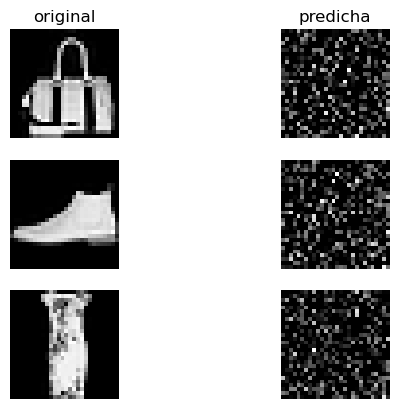

In [295]:
model_test(model,'1e1_pred.png')

### Prueba de distintos learning rates

Decidi hacer que busque entre el mejor lr, y el mejor numero de neuronas, en la proxima voy a buscar algun criterio para quedarme con el mejor de todos y observar como predice.

In [296]:
# pruebo cual de los 3 lr y entre todos los conjuntos de neuronas de la capá intermedia anda mejor

# import shelve
# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
# #achique la lista porque corrompi sin querer los archivos al correr de vuelta sobre el mismo directorio
# list_of_models = ['SGD_lr1e-1_n_','SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 

# list_learning_rate = [1e-1,1e-2,1e-3]

# neuron_numbers = [64,128,256,512]

# # neuron_numbers = [64]

# for lr,model_i in enumerate(list_of_models):
    
#     for neuron in neuron_numbers:
#         n = neuron
#         model = Autoencoder(n)
#         num_epochs = 100
#         list_avg_train_loss = []
#         list_avg_test_loss = []
#         list_avg_test_train_loss = []
#         # learning_rate = np.linspace(1e-3,1e-1,num_epochs)[::-1]
#         optimizer = torch.optim.SGD(model.parameters(),lr=list_learning_rate[lr],momentum=0.9)
        
#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)
            

#         models = shelve.open(path + model_i+str(neuron)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss

#         models.close()
#         print(model_i + "Done!")

Necesito seleccionar de alguna manera sensata los mejores modelos, para eso y dado que estoy trabajando para el mismo numero de epocas voy a tomar los 4 modelos que mejor funcionen para ello, voy a tomar aquellos que tengan el menor promedio en test contanto el ultimo 10% de las muestras en test (como para tener una idea del desempeño) y posteriormente los voy a plotear. 
Para finalizar me voy q quedar con el que mejor rendimiento obtenga

In [356]:
# de aca guardo en un diccionario cuales son los modelos con menor loss
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
neuron_numbers = [64,128,256,512]
list_of_models = ['SGD_lr1e-1_n_','SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 

plt.figure(figsize=(5,4))

dyct_SGD = {}

for model in list_of_models:
    for n in neuron_numbers:
        model_name = model+ str(n) +".db"
        modelos_=shelve.open(path + model_name)

        # list_avg_train_loss = modelos_['test_train_loss'][-10:].mean()  # notar que tome el test_train_loss
        best_10 = np.mean(modelos_['test_loss'][-10:])
        dyct_SGD[model_name] = best_10


<Figure size 500x400 with 0 Axes>

Ordeno los resultados para obtener los 4 mejores. 

In [357]:
sorted(dyct_SGD.items(), key=lambda item: item[1])[:4] # todos pertenecen a el lr de 1e-1

[('SGD_lr1e-1_n_512.db', 0.014241206953302023),
 ('SGD_lr1e-1_n_256.db', 0.01852587625384331),
 ('SGD_lr1e-1_n_128.db', 0.021262466516345738),
 ('SGD_lr1e-1_n_64.db', 0.026710779797285793)]

### Graficador de resultados

Ploteo los resultados, para los 4 mejores resultados. 

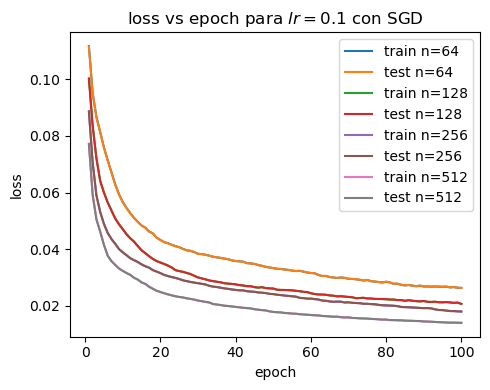

In [474]:
# graficador de loss
%matplotlib inline
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
neuron_numbers = [64,128,256,512]
plt.figure(figsize=(5,4))
for n in neuron_numbers:

    modelos_=shelve.open(path + "SGD_lr1e-1_n_"+ str(n) +".db")

    list_avg_train_loss = modelos_['test_train_loss']
    list_avg_test_loss = modelos_['test_loss']
    plt.xlabel('epoch')
    plt.ylabel('loss')
    # plt.xlim(-0.1,5.1)
    # plt.ylim(-0.1,1.1)
    plt.title('loss vs epoch para $lr = 0.1$ con SGD')
    plt.plot(range(1,len(list_avg_train_loss)+1),list_avg_train_loss,label="train n=" +str(n),linestyle='-',)
    plt.plot(range(1,len(list_avg_test_loss)+1),list_avg_test_loss,label="test n="+str(n),linestyle='-')
    plt.tight_layout()
    plt.legend()

# path  + "SGD_lr1e-1_n_"+ str(128) +".db"
plt.savefig(path + 'best_lr_variando_neuronasSGD.png')

### Veamos como predice el modelo con menor error

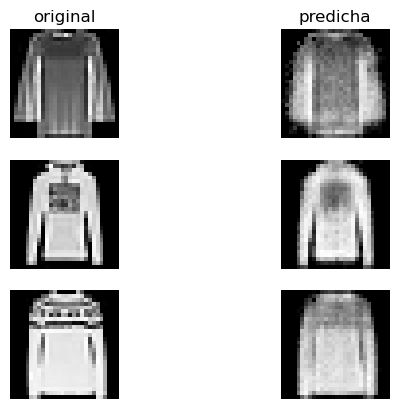

In [364]:
# de lo anterior, observo que el modelo que mejor predijo es el de 512 neuronas y lr=1e-1 
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"
model_name = "SGD_lr1e-1_n_"+ str(512)
modelos_=shelve.open(path +  model_name+".db")

model = modelos_['auto'] # notar que tome el test_train_loss
model_test(model,model_name +'.png')

### Ahora cambio el optimizador


In [301]:
# import shelve
# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

# list_learning_rate = [1e-1,1e-2,1e-3]

# # neuron_numbers = [64,128,256,512]

# neuron_numbers = [64]

# for lr,model_i in enumerate(list_of_models):
    
#     for neuron in neuron_numbers:
#         lr = list_learning_rate[lr]
#         n = neuron
#         print(model_i+str(n)+"_lr = "+str(lr))
#         model = Autoencoder(n)
#         num_epochs = 5
        
#         list_avg_train_loss = []
#         list_avg_test_loss = []
#         list_avg_test_train_loss = []
#         optimizer = torch.optim.Adam(model.parameters(),lr=lr,eps=1e-08,weight_decay=0,amsgrad=False)
        
#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
            
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)

            
#         models = shelve.open(path + model_i+str(neuron)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss
        
#         models.close()
#         print(model_i + "Done!")

In [302]:
# import shelve
# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"

# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

# list_learning_rate = [1e-1,1e-2,1e-3]

# neuron_numbers = [64,128,256,512]

# # neuron_numbers = [64]

# for lr,model_i in enumerate(list_of_models):
    
#     for neuron in neuron_numbers:
#         n = neuron
#         model = Autoencoder(n)
#         num_epochs = 100
#         list_avg_train_loss = []
#         list_avg_test_loss = []
#         list_avg_test_train_loss = []
#         # learning_rate = np.linspace(1e-3,1e-1,num_epochs)[::-1]
#         loss_fn = nn.MSELoss()

#         # optimizer = torch.optim.SGD(model.parameters(),lr=list_learning_rate[lr],momentum=0.9)
#         optimizer = torch.optim.Adam(model.parameters(),lr=list_learning_rate[lr],eps=1e-08,weight_decay=0,amsgrad=False)

#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)
            

#         models = shelve.open(path + model_i+str(neuron)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss

#         models.close()
#         print(model_i + "Done!")

In [328]:
# de aca guardo en un diccionario cuales son los modelos con menor loss
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
neuron_numbers = [64,128,256,512]
list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

dyct_adam = {}

for model in list_of_models:
    for n in neuron_numbers:
        model_name = model+ str(n) +".db"
        modelos_=shelve.open(path + model_name)

        # list_avg_train_loss = modelos_['test_train_loss'][-10:].mean()  # notar que tome el test_train_loss
        best_10 = np.mean(modelos_['test_loss'][-10:])
        dyct_adam[model_name] = best_10


In [329]:
sorted(dyct_adam.items(), key=lambda item: item[1])[:12] # todos pertenecen a el lr de 1e-1

[('adam_lr1e-3_n_512.db', 0.007386826062574983),
 ('adam_lr1e-3_n_256.db', 0.009186674281954767),
 ('adam_lr1e-3_n_128.db', 0.010878186654299498),
 ('adam_lr1e-3_n_64.db', 0.015299956137314438),
 ('adam_lr1e-2_n_512.db', 0.0363800247758627),
 ('adam_lr1e-2_n_256.db', 0.05763834405690431),
 ('adam_lr1e-2_n_128.db', 0.07962575659155845),
 ('adam_lr1e-2_n_64.db', 0.09075610980391502),
 ('adam_lr1e-1_n_128.db', 0.20498275443911554),
 ('adam_lr1e-1_n_256.db', 0.20642760068178173),
 ('adam_lr1e-1_n_512.db', 0.20649939730763434),
 ('adam_lr1e-1_n_64.db', 0.2064994016289711)]

In [305]:
# graficador de loss
# %matplotlib qt
# path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
# neuron_numbers = [64,128,256,512]
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 
# markers = [".","*","x","+"]
# plt.figure(figsize=(10,3.5))
# for i, model in enumerate(list_of_models):
#     for n in neuron_numbers:

#         modelos_=shelve.open(path + model + str(n) +".db")

#         list_avg_train_loss = modelos_['train_loss']
#         list_avg_test_loss = modelos_['test_loss']
#         plt.xlabel('epoch')
#         plt.ylabel('loss')
#         plt.xlim(80,106)
#         plt.ylim(0.005,0.018)
#         # plt.scatter(range(1,len(list_avg_train_loss)+1),list_avg_train_loss,label="train"+model[4:]+str(n),marker=markers[i])
#         plt.scatter(range(1,len(list_avg_test_loss)+1),list_avg_test_loss,label='lr ='+ model[7:11]+", n="+str(n),marker=markers[i])
#         plt.title('Perdida en función de la epoca utilizando adam como optimizador')
#         plt.legend()

# plt.savefig('adam_full.png')

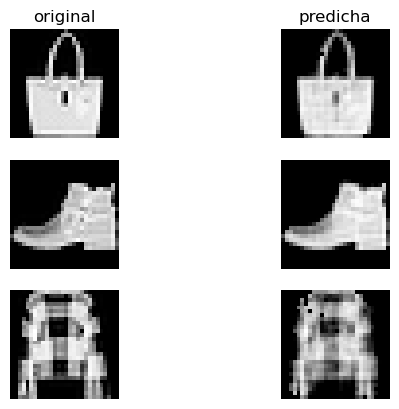

In [330]:
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
model_name = "adam_lr1e-3_n_"+ str(512)
modelos_=shelve.open(path +  model_name+".db")

model = modelos_['auto'] 
model_test(model,model_name +'.png')

In [306]:
# # custom trainer

# num_epochs = 100
# list_avg_train_loss = []
# list_avg_test_loss = []
# learning_rate = np.linspace(1e-3,1e-1,num_epochs)[::-1]

# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}\n-------------------------------")
    
#     optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate[epoch])
#     avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#     avg_test_loss = test_loop(testloader,model,loss_fn)
#     list_avg_train_loss.append(avg_train_loss)
#     list_avg_test_loss.append(avg_test_loss)
# print("Done!")

## Modelo final y autoencoder

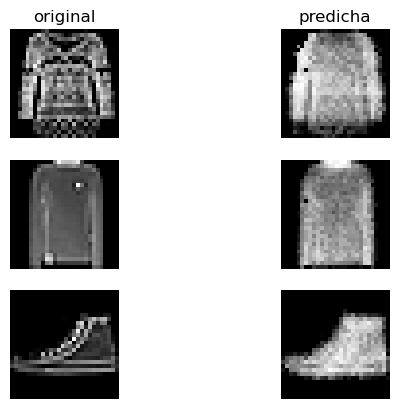

In [316]:
%matplotlib inline
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"

modelo_final = shelve.open(path + "adam_lr1e-3_n_512.db")
model = modelo_final['auto']
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = trainset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")    
plt.show()

In [308]:
# show = torch.tensor(model(image).reshape(28,28))
# plt.imshow(show)

### Defino una clase para meter ruido gaussiano

In [331]:
class AddGaussianNoise(ToTensor):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor,soft):
        return tensor + (torch.randn(tensor.size()) * self.std + self.mean)/soft
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Probamos como funciona el ruido gaussiano

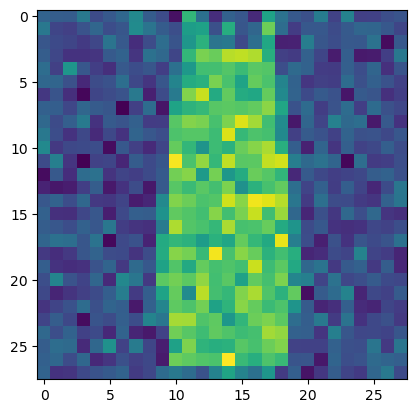

In [332]:
soft = 7
image_gau = AddGaussianNoise().__call__(image,soft)
plt.imshow(image_gau.squeeze())

/tmp/ipykernel_131545/517567783.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  show = torch.tensor(model(image_gau).reshape(28,28))


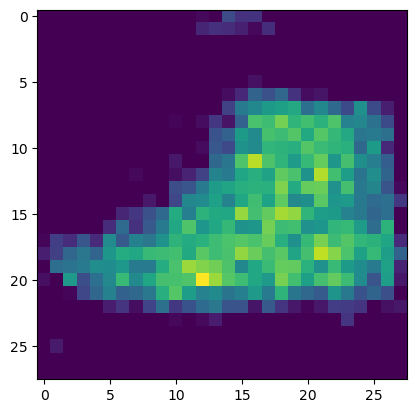

In [319]:
show = torch.tensor(model(image_gau).reshape(28,28))
plt.imshow(show)

Ahora voy a generalizar lo que hice antes, voy a probar ensuciando con un ruido gaussiano las imagenes para ver si las limpia


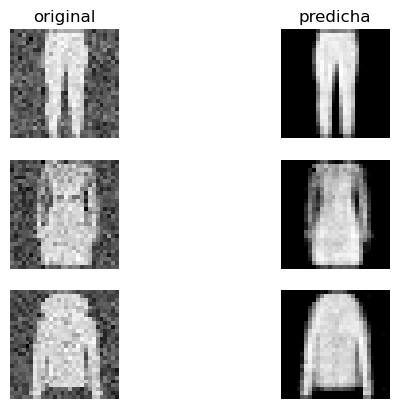

<Figure size 640x480 with 0 Axes>

In [370]:
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"

modelo_final = shelve.open(path + "SGD_lr1e-1_n_512.db")
model = modelo_final['auto']

figure = plt.figure()
rows,cols = 3,2
soft=7
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")    
plt.show()
plt.savefig('adam_filtrando.png')

2577 1
9708 2
8946 3


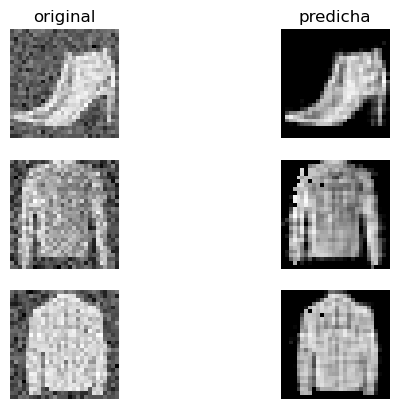

<Figure size 640x480 with 0 Axes>

In [403]:
path = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"

modelo_final = shelve.open(path + "adam_lr1e-3_n_512.db")
model = modelo_final['auto']

figure = plt.figure()
rows,cols = 3,2
soft=7
i = 0 # subplot index
jotas = [5087]
for row in range(1,rows+1):
    j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    print(j,row)
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #plt.imshow(image_pred,cmap="Greys_r")
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu = model(image_gpu)
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")    
plt.show()
plt.savefig('Adam_filtrando.png')

1070 1
8055 2
7900 3
4053 4


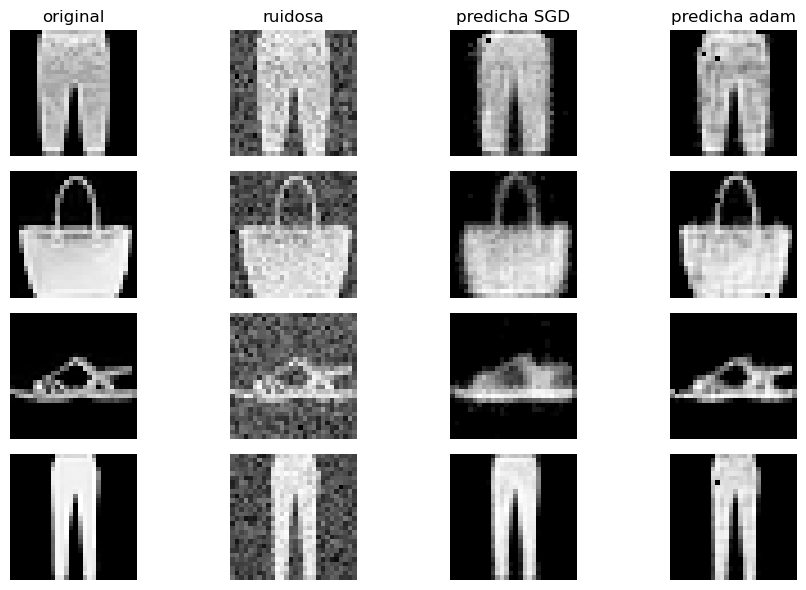

<Figure size 640x480 with 0 Axes>

In [469]:
path_adam = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
path_SGD = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"

modelo_final_adam = shelve.open(path_adam + "adam_lr1e-3_n_512.db")
model_adam = modelo_final_adam['auto']

modelo_final_SGD = shelve.open(path_SGD + "SGD_lr1e-1_n_512.db")
model_SGD = modelo_final_SGD['auto']

figure = plt.figure(figsize=(10,6))
rows,cols = 4,4
soft=9
i = 0 # subplot index
# jotas = [5087]
for row in range(1,rows+1):
    j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    print(j,row)
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    # image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # ploteamos la imagen ruidosa
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("ruidosa")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha con sgd
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha SGD")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu1 = model_SGD(image_gpu)
    pred_cpu1 = pred_gpu1.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu1,cmap="Greys_r")   
     
    # Ploteamos la imagen predicha con adam
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha adam")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu2 = model_adam(image_gpu)
    pred_cpu2 = pred_gpu2.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu2,cmap="Greys_r")    
    
    plt.tight_layout()
    
plt.show()
plt.savefig('Comparacion de modelos.png')

8568 1
4843 2
4053 3
5105 4


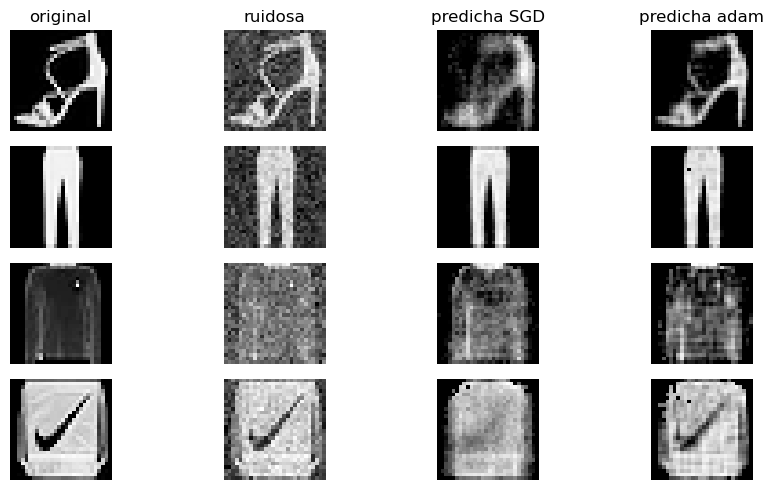

In [473]:
jotas=[4843,4053,5105,8568 ]
path_adam = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/adam_todos_lr_todas_neuronas/"
path_SGD = "/media/data/Documentos de Programacion/Documentos Python/Curso neurociencia/practicos/modelos entrenados/"

modelo_final_adam = shelve.open(path_adam + "adam_lr1e-3_n_512.db")
model_adam = modelo_final_adam['auto']

modelo_final_SGD = shelve.open(path_SGD + "SGD_lr1e-1_n_512.db")
model_SGD = modelo_final_SGD['auto']

figure = plt.figure(figsize=(10,5))
rows,cols = 4,4
soft=9
i = 0 # subplot index
# jotas = [5087]
for row in range(1,rows+1):
    # j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    print(j,row)
    j = jotas[row-1]
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    # image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # ploteamos la imagen ruidosa
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("ruidosa")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha con sgd
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha SGD")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu1 = model_SGD(image_gpu)
    pred_cpu1 = pred_gpu1.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu1,cmap="Greys_r")   
     
    # Ploteamos la imagen predicha con adam
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha adam")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu2 = model_adam(image_gpu)
    pred_cpu2 = pred_gpu2.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu2,cmap="Greys_r")    
    
    plt.tight_layout()
    
# plt.show()
plt.savefig('Comparacion de modelos.png')